In [50]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Resolver ruta del dataset de forma robusta
fname = "SouthGermanCredit.asc"
candidate_paths = [
    Path("/home/camilo-arch/machine-learning/introduccion/notebooks/data") / fname,
    Path.cwd() / "data" / fname,
    Path.cwd() / "notebooks" / "data" / fname,
    Path.cwd().parent / "notebooks" / "data" / fname,
    Path.cwd().parent / "data" / fname,
]
DATA_PATH = None
for p in candidate_paths:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(f"No se encontró {fname}. Intentado en: " + ", ".join(map(str, candidate_paths)))

# Cargar datos: separador por espacios y encabezado en la primera línea
# La primera fila del archivo contiene los nombres de columnas
df = pd.read_csv(DATA_PATH, sep=r"\s+", header=0)

# Objetivo: 1 = pagó, 0 = no pagó (ya viene 0/1 en la última columna)
y = df["kredit"].astype(int).values
X = df.drop(columns=["kredit"]).values.astype(float)
feature_cols = df.drop(columns=["kredit"]).columns.tolist()

# Split manual estratificado 60/20/20 (train/val/test) sin sklearn
rng = np.random.default_rng(42)
idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == 0)[0]
rng.shuffle(idx_pos)
rng.shuffle(idx_neg)

val_ratio = 0.20
test_ratio = 0.20
n_pos_test = int(round(len(idx_pos) * test_ratio))
n_neg_test = int(round(len(idx_neg) * test_ratio))
n_pos_val = int(round(len(idx_pos) * val_ratio))
n_neg_val = int(round(len(idx_neg) * val_ratio))

# Índices por clase
test_idx = np.concatenate([idx_pos[:n_pos_test], idx_neg[:n_neg_test]])
val_idx  = np.concatenate([idx_pos[n_pos_test:n_pos_test+n_pos_val], idx_neg[n_neg_test:n_neg_test+n_neg_val]])
train_idx = np.concatenate([idx_pos[n_pos_test+n_pos_val:], idx_neg[n_neg_test+n_neg_val:]])

# Mezclar conjuntos finales para eliminar orden por clase
rng.shuffle(train_idx)
rng.shuffle(val_idx)
rng.shuffle(test_idx)

# Arrays para modelado
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]
X_test = X[test_idx]
y_test = y[test_idx]

# Estandarización manual: z = (x - mean) / std (con protección std=0)
mean_ = X_train.mean(axis=0)
std_ = X_train.std(axis=0)
std_[std_ == 0] = 1.0
X_train = (X_train - mean_) / std_
X_val   = (X_val   - mean_) / std_
X_test  = (X_test  - mean_) / std_

# Polinomización (NumPy) - opción B integrada
# Configuración: columnas, grado e interacciones
POLY_COLUMNS = feature_cols               # usa todas las columnas; cambia a una lista para subset
POLY_DEGREE = 1                         # grado máximo (>=2)
POLY_INTERACTIONS = False                 # True para incluir productos entre columnas

# Mapear nombres a índices
poly_indices = [feature_cols.index(c) for c in POLY_COLUMNS]

# Construcción de matrices aumentadas por split
parts_train, parts_val, parts_test = [X_train], [X_val], [X_test]
feature_cols_aug = list(feature_cols)

# Potencias por columna (sin interacciones)
for j in poly_indices:
    col = feature_cols[j]
    z_tr = X_train[:, j:j+1]
    z_va = X_val[:,   j:j+1]
    z_te = X_test[:,  j:j+1]
    for p in range(2, POLY_DEGREE + 1):
        parts_train.append(z_tr ** p)
        parts_val.append(z_va ** p)
        parts_test.append(z_te ** p)
        feature_cols_aug.append(f"{col}^{p}")

# Interacciones opcionales
if POLY_INTERACTIONS:
    for a in range(len(poly_indices)):
        for b in range(a + 1, len(poly_indices)):
            i, j = poly_indices[a], poly_indices[b]
            parts_train.append(X_train[:, [i]] * X_train[:, [j]])
            parts_val.append(  X_val[:,   [i]] * X_val[:,   [j]])
            parts_test.append( X_test[:,  [i]] * X_test[:,  [j]])
            feature_cols_aug.append(f"{feature_cols[i]}*{feature_cols[j]}")

# Ensamblar
X_train = np.hstack(parts_train)
X_val   = np.hstack(parts_val)
X_test  = np.hstack(parts_test)

# (Opcional) re-escalado tras la expansión para estabilizar el entrenamiento
mean2_ = X_train.mean(axis=0)
std2_ = X_train.std(axis=0)
std2_[std2_ == 0] = 1.0
X_train = (X_train - mean2_) / std2_
X_val   = (X_val   - mean2_) / std2_
X_test  = (X_test  - mean2_) / std2_

# DataFrames por split (para análisis/gráfica)
df_train = df.iloc[train_idx].copy(); df_train["split"] = "train"
df_val   = df.iloc[val_idx].copy();   df_val["split"]   = "val"
df_test  = df.iloc[test_idx].copy();  df_test["split"]  = "test"

df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)

X_train.shape, X_val.shape, X_test.shape, y_train.mean(), y_val.mean(), y_test.mean()


((600, 20), (200, 20), (200, 20), 0.7, 0.7, 0.7)

In [51]:
import numpy as np
from tqdm import tqdm

# Funciones portadas desde LR_From_scratch (adaptadas a este dataset)

def initialize_weights(row_vector: np.ndarray, method: str = "zeros", random_scale: float = 0.01, random_state: int | None = None):
    """
    Inicializa los parámetros del modelo.

    Entradas:
    - row_vector (np.ndarray): vector de características (1D) usado solo para inferir la dimensión de w.
    - method (str): 'zeros' para ceros o 'random' para inicialización aleatoria.
    - random_scale (float): desviación estándar para w ~ N(0, random_scale^2) si method='random'.
    - random_state (int | None): semilla para reproducibilidad (solo si method='random').

    Salidas:
    - w (np.ndarray): vector de pesos inicializado (ceros o aleatorio).
    - b (float): sesgo inicializado en 0.0.

    Fórmulas:
    - Si method='zeros': w := 0, b := 0
    - Si method='random': w ~ N(0, random_scale^2), b := 0
    """
    if method == "zeros":
        w = np.zeros_like(row_vector)
    elif method == "random":
        rng = np.random.default_rng(random_state)
        w = rng.normal(loc=0.0, scale=random_scale, size=row_vector.shape)
    else:
        raise ValueError("method debe ser 'zeros' o 'random'")
    b = 0.0
    return w, b


def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Función sigmoide.

    Entradas:
    - z (np.ndarray): escalar o arreglo con valores reales.

    Salidas:
    - (np.ndarray): σ(z) aplicada elemento a elemento.

    Fórmula:
    - σ(z) = 1 / (1 + e^{-z})
    """
    return 1.0 / (1.0 + np.exp(-z))


def logloss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Pérdida logarítmica (log-loss) binaria promedio.

    Entradas:
    - y_true (np.ndarray): etiquetas verdaderas en {0,1}, forma (N,).
    - y_pred (np.ndarray): probabilidades predichas en (0,1), forma (N,).

    Salidas:
    - (float): pérdida promedio sobre N ejemplos.

    Fórmula:
    - L = -\frac{1}{N} \sum_{i=1}^{N} [ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) ]
    """
    # Evitar log(0)
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    n = y_true.shape[0]
    loss = - (np.dot(y_true, np.log(y_pred)) + np.dot((1 - y_true), np.log(1 - y_pred))) / n
    return float(loss)


def gradient_dw(x: np.ndarray, y: float, w: np.ndarray, b: float, alpha: float, N: int) -> np.ndarray:
    """
    Gradiente de la pérdida respecto a w para un ejemplo (con regularización L2).

    Entradas:
    - x (np.ndarray): vector de características del ejemplo, forma (D,).
    - y (float): etiqueta verdadera en {0,1}.
    - w (np.ndarray): pesos actuales, forma (D,).
    - b (float): sesgo actual.
    - alpha (float): fuerza de regularización L2.
    - N (int): número total de ejemplos en el conjunto de entrenamiento.

    Salidas:
    - (np.ndarray): gradiente ∂L/∂w para este ejemplo.

    Fórmula:
    - \nabla_w = x ( y - σ(w^T x + b) ) - (α / N) w
    """
    return (x * (y - sigmoid(np.dot(w, x) + b))) - ((alpha / N) * w)


def gradient_db(x: np.ndarray, y: float, w: np.ndarray, b: float) -> float:
    """
    Gradiente de la pérdida respecto a b para un ejemplo.

    Entradas:
    - x (np.ndarray): vector de características del ejemplo, forma (D,).
    - y (float): etiqueta verdadera en {0,1}.
    - w (np.ndarray): pesos actuales, forma (D,).
    - b (float): sesgo actual.

    Salidas:
    - (float): gradiente ∂L/∂b para este ejemplo.

    Fórmula:
    - \nabla_b = y - σ(w^T x + b)
    """
    return float(y - sigmoid(np.dot(w, x) + b))


def predict_probabilities(w: np.ndarray, b: float, X: np.ndarray) -> np.ndarray:
    """
    Calcula probabilidades predichas para un conjunto de ejemplos.

    Entradas:
    - w (np.ndarray): pesos del modelo, forma (D,).
    - b (float): sesgo del modelo.
    - X (np.ndarray): matriz de características, forma (N, D).

    Salidas:
    - (np.ndarray): probabilidades σ(X w + b), forma (N,).

    Fórmula:
    - p = σ(X w + b)
    """
    z = X @ w + b
    return sigmoid(z)


def train_logreg_sgd(X_train: np.ndarray, y_train: np.ndarray,
                     X_val: np.ndarray, y_val: np.ndarray,
                     epochs: int, alpha: float, eta0: float,
                     init_method: str = "random", init_scale: float = 0.01, init_seed: int | None = None):
    """
    Entrena una regresión logística binaria con SGD y regularización L2.

    Entradas:
    - X_train (np.ndarray): matriz (N, D) de entrenamiento.
    - y_train (np.ndarray): etiquetas (N,) en {0,1} de entrenamiento.
    - X_val (np.ndarray): matriz (N_val, D) de validación/prueba.
    - y_val (np.ndarray): etiquetas (N_val,) en {0,1} de validación/prueba.
    - epochs (int): número máximo de épocas.
    - alpha (float): fuerza de regularización L2.
    - eta0 (float): tasa de aprendizaje (learning rate).
    - init_method (str): 'zeros' o 'random' para la inicialización de w.
    - init_scale (float): desviación estándar para inicialización aleatoria.
    - init_seed (int | None): semilla para reproducibilidad de la inicialización aleatoria.

    Salidas:
    - w (np.ndarray): pesos aprendidos, forma (D,).
    - b (float): sesgo aprendido.
    - train_loss (list[float]): historial de pérdidas en entrenamiento por época.
    - val_loss (list[float]): historial de pérdidas en validación por época.

    Fórmulas y regla de actualización (por ejemplo):
    - \nabla_w = x ( y - σ(w^T x + b) ) - (α / N) w
    - \nabla_b = y - σ(w^T x + b)
    - w_{t+1} = w_t + η_0 \nabla_w
    - b_{t+1} = b_t + η_0 \nabla_b
    """
    train_loss, val_loss = [], []
    w, b = initialize_weights(X_train[0], method=init_method, random_scale=init_scale, random_state=init_seed)
    N = X_train.shape[0]

    for e in tqdm(range(epochs)):
        for i in range(N):
            dw = gradient_dw(X_train[i], y_train[i], w, b, alpha, N)
            db = gradient_db(X_train[i], y_train[i], w, b)
            w += eta0 * dw
            b += eta0 * db

        y_train_pred = predict_probabilities(w, b, X_train)
        y_val_pred = predict_probabilities(w, b, X_val)
        train_loss.append(logloss(y_train, y_train_pred))
        val_loss.append(logloss(y_val, y_val_pred))

        if e > 0 and abs(train_loss[-1] - train_loss[-2]) < 1e-7:
            break

    return w, b, train_loss, val_loss


  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 6/200 [00:00<00:02, 72.41it/s]


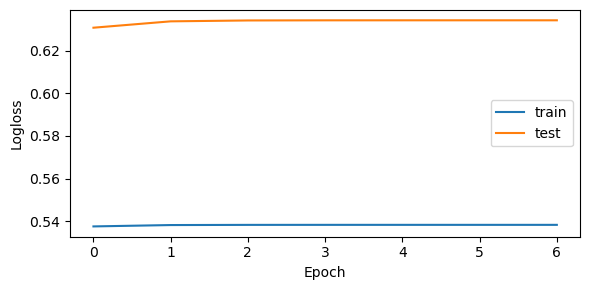

Accuracy: 0.720
ROC AUC: 0.728
Matriz de confusión:
 [[ 31  29]
 [ 27 113]]

Métricas clase 1 (positivo):
Precision: 0.796, Recall: 0.807, F1: 0.801
Métricas clase 0 (negativo):
Precision: 0.534, Recall: 0.517, F1: 0.525


In [52]:


# Hiperparámetros
alpha = 0.01   # L2
eta0 = 0.1    # LR un poco mayor que en el notebook sintético
epochs = 200

w, b, train_loss, val_loss = train_logreg_sgd(
    X_train, y_train, X_test, y_test, epochs=epochs, alpha=alpha, eta0=eta0, init_method="random"
)

# Curvas de pérdida
plt.figure(figsize=(6,3))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="test")
plt.xlabel("Epoch")
plt.ylabel("Logloss")
plt.legend()
plt.tight_layout()
plt.show()

# Predicciones y métricas (sin sklearn)
probas = predict_probabilities(w, b, X_test)
y_pred = (probas >= 0.5).astype(int)

# Accuracy
acc = float(np.mean(y_pred == y_test))

# Matriz de confusión manual
TP = int(np.sum((y_test == 1) & (y_pred == 1)))
TN = int(np.sum((y_test == 0) & (y_pred == 0)))
FP = int(np.sum((y_test == 0) & (y_pred == 1)))
FN = int(np.sum((y_test == 1) & (y_pred == 0)))
cm = np.array([[TN, FP], [FN, TP]])

# ROC AUC con NumPy (cálculo por curva ROC discreta)
def roc_auc_score_np(y_true: np.ndarray, y_score: np.ndarray) -> float:
    y_true = y_true.astype(int)
    n_pos = int(np.sum(y_true == 1))
    n_neg = int(np.sum(y_true == 0))
    if n_pos == 0 or n_neg == 0:
        return float("nan")
    order = np.argsort(-y_score)
    y_sorted = y_true[order]
    tps = np.cumsum(y_sorted)
    fps = np.cumsum(1 - y_sorted)
    tpr = tps / n_pos
    fpr = fps / n_neg
    tpr = np.concatenate(([0.0], tpr))
    fpr = np.concatenate(([0.0], fpr))
    return float(np.trapz(tpr, fpr))

auc = roc_auc_score_np(y_test, probas)

# Métricas por clase
prec1 = TP / (TP + FP) if (TP + FP) > 0 else 0.0
rec1  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1_1  = 2 * prec1 * rec1 / (prec1 + rec1) if (prec1 + rec1) > 0 else 0.0

prec0 = TN / (TN + FN) if (TN + FN) > 0 else 0.0
rec0  = TN / (TN + FP) if (TN + FP) > 0 else 0.0
f1_0  = 2 * prec0 * rec0 / (prec0 + rec0) if (prec0 + rec0) > 0 else 0.0

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")
print("Matriz de confusión:\n", cm)
print("\nMétricas clase 1 (positivo):")
print(f"Precision: {prec1:.3f}, Recall: {rec1:.3f}, F1: {f1_1:.3f}")
print("Métricas clase 0 (negativo):")
print(f"Precision: {prec0:.3f}, Recall: {rec0:.3f}, F1: {f1_0:.3f}")


100%|██████████| 200/200 [00:01<00:00, 165.54it/s]


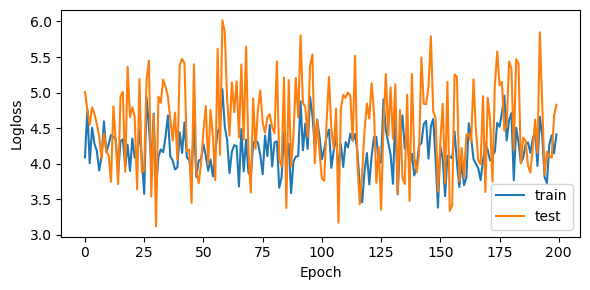

Accuracy: 0.640
ROC AUC: 0.629
Matriz de confusión:
 [[ 25  35]
 [ 37 103]]

Métricas clase 1 (positivo):
Precision: 0.746, Recall: 0.736, F1: 0.741
Métricas clase 0 (negativo):
Precision: 0.403, Recall: 0.417, F1: 0.410


In [53]:
# Hiperparámetros
alpha = 0.01   # L2
eta0 = 2    # LR un poco mayor que en el notebook sintético
epochs = 200

w, b, train_loss, val_loss = train_logreg_sgd(
    X_train, y_train, X_test, y_test, epochs=epochs, alpha=alpha, eta0=eta0, init_method="random"
)

# Curvas de pérdida
plt.figure(figsize=(6,3))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="test")
plt.xlabel("Epoch")
plt.ylabel("Logloss")
plt.legend()
plt.tight_layout()
plt.show()

# Predicciones y métricas (sin sklearn)
probas = predict_probabilities(w, b, X_test)
y_pred = (probas >= 0.5).astype(int)

# Accuracy
acc = float(np.mean(y_pred == y_test))

# Matriz de confusión manual
TP = int(np.sum((y_test == 1) & (y_pred == 1)))
TN = int(np.sum((y_test == 0) & (y_pred == 0)))
FP = int(np.sum((y_test == 0) & (y_pred == 1)))
FN = int(np.sum((y_test == 1) & (y_pred == 0)))
cm = np.array([[TN, FP], [FN, TP]])

# ROC AUC con NumPy (cálculo por curva ROC discreta)
def roc_auc_score_np(y_true: np.ndarray, y_score: np.ndarray) -> float:
    y_true = y_true.astype(int)
    n_pos = int(np.sum(y_true == 1))
    n_neg = int(np.sum(y_true == 0))
    if n_pos == 0 or n_neg == 0:
        return float("nan")
    order = np.argsort(-y_score)
    y_sorted = y_true[order]
    tps = np.cumsum(y_sorted)
    fps = np.cumsum(1 - y_sorted)
    tpr = tps / n_pos
    fpr = fps / n_neg
    tpr = np.concatenate(([0.0], tpr))
    fpr = np.concatenate(([0.0], fpr))
    return float(np.trapz(tpr, fpr))

auc = roc_auc_score_np(y_test, probas)

# Métricas por clase
prec1 = TP / (TP + FP) if (TP + FP) > 0 else 0.0
rec1  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1_1  = 2 * prec1 * rec1 / (prec1 + rec1) if (prec1 + rec1) > 0 else 0.0

prec0 = TN / (TN + FN) if (TN + FN) > 0 else 0.0
rec0  = TN / (TN + FP) if (TN + FP) > 0 else 0.0
f1_0  = 2 * prec0 * rec0 / (prec0 + rec0) if (prec0 + rec0) > 0 else 0.0

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")
print("Matriz de confusión:\n", cm)
print("\nMétricas clase 1 (positivo):")
print(f"Precision: {prec1:.3f}, Recall: {rec1:.3f}, F1: {f1_1:.3f}")
print("Métricas clase 0 (negativo):")
print(f"Precision: {prec0:.3f}, Recall: {rec0:.3f}, F1: {f1_0:.3f}")

In [54]:
# Comparación de métricas: train vs val vs test (mismo formato)
import numpy as np
import pandas as pd


def compute_metrics(X, y):
    probas = predict_probabilities(w, b, X)
    y_pred = (probas >= 0.5).astype(int)
    acc = float(np.mean(y_pred == y))
    TP = int(np.sum((y == 1) & (y_pred == 1)))
    TN = int(np.sum((y == 0) & (y_pred == 0)))
    FP = int(np.sum((y == 0) & (y_pred == 1)))
    FN = int(np.sum((y == 1) & (y_pred == 0)))
    auc = roc_auc_score_np(y, probas)

    prec1 = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    rec1  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_1  = 2 * prec1 * rec1 / (prec1 + rec1) if (prec1 + rec1) > 0 else 0.0

    prec0 = TN / (TN + FN) if (TN + FN) > 0 else 0.0
    rec0  = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    f1_0  = 2 * prec0 * rec0 / (prec0 + rec0) if (prec0 + rec0) > 0 else 0.0

    return {
        "accuracy": acc, "auc": auc,
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "prec_pos": prec1, "rec_pos": rec1, "f1_pos": f1_1,
        "prec_neg": prec0, "rec_neg": rec0, "f1_neg": f1_0,
    }

results = {
    "train": compute_metrics(X_train, y_train),
    "val":   compute_metrics(X_val, y_val),
    "test":  compute_metrics(X_test, y_test),
}

# Impresión tipo "como acá" por split
for split in ["train", "val", "test"]:
    m = results[split]
    cm = np.array([[m["TN"], m["FP"]], [m["FN"], m["TP"]]])
    print(f"=== {split.upper()} ===")
    print(f"Accuracy: {m['accuracy']:.3f}")
    print(f"ROC AUC: {m['auc']:.3f}")
    print("Matriz de confusión:\n", cm)
    print("\nMétricas clase 1 (positivo):")
    print(f"Precision: {m['prec_pos']:.3f}, Recall: {m['rec_pos']:.3f}, F1: {m['f1_pos']:.3f}")
    print("Métricas clase 0 (negativo):")
    print(f"Precision: {m['prec_neg']:.3f}, Recall: {m['rec_neg']:.3f}, F1: {m['f1_neg']:.3f}")
    print()

# Resumen en DataFrame
summary = pd.DataFrame.from_dict(results, orient="index")
summary


=== TRAIN ===
Accuracy: 0.697
ROC AUC: 0.695
Matriz de confusión:
 [[ 86  94]
 [ 88 332]]

Métricas clase 1 (positivo):
Precision: 0.779, Recall: 0.790, F1: 0.785
Métricas clase 0 (negativo):
Precision: 0.494, Recall: 0.478, F1: 0.486

=== VAL ===
Accuracy: 0.655
ROC AUC: 0.664
Matriz de confusión:
 [[ 28  32]
 [ 37 103]]

Métricas clase 1 (positivo):
Precision: 0.763, Recall: 0.736, F1: 0.749
Métricas clase 0 (negativo):
Precision: 0.431, Recall: 0.467, F1: 0.448

=== TEST ===
Accuracy: 0.640
ROC AUC: 0.629
Matriz de confusión:
 [[ 25  35]
 [ 37 103]]

Métricas clase 1 (positivo):
Precision: 0.746, Recall: 0.736, F1: 0.741
Métricas clase 0 (negativo):
Precision: 0.403, Recall: 0.417, F1: 0.410



,accuracy,auc,TP,FP,FN,TN,prec_pos,rec_pos,f1_pos,prec_neg,rec_neg,f1_neg
train,0.696667,0.695384,332,94,88,86,0.779343,0.790476,0.784870,0.494253,0.477778,0.485876
val,0.655000,0.663810,103,32,37,28,0.762963,0.735714,0.749091,0.430769,0.466667,0.448000
test,0.640000,0.628810,103,35,37,25,0.746377,0.735714,0.741007,0.403226,0.416667,0.409836
